# Hello Bluesky: Reading detectors and scanning

In this notebook you will:

* Connect to some simulated hardware.
* Acquire some data via two common experimental procedures ("plans"), ``count`` and ``scan``.
* Write a custom plan.

Recommend Prerequisites:

* [Hello Python and Jupyter](./Hello%20Python%20and%20Jupyter.ipynb)

## Configuration
Below, we will connect to EPICS IOC(s) controlling simulated hardware in lieu of actual motors and detectors. An EPICS IOC is control system software that allows communication with a wide variety of hardware using a common interface. The IOCs should already be running in the background. Run this command to verify that they are running: it should produce output with RUNNING on each line. In the event of a problem, edit this command to replace `status` with `restart all` and run again.

In [1]:
%matplotlib widget

In [2]:
!supervisorctl -c supervisor/supervisord.conf status

decay                            RUNNING   pid 4811, uptime 0:01:00
mini_beamline                    RUNNING   pid 4812, uptime 0:01:00
random_walk                      RUNNING   pid 4813, uptime 0:01:00
random_walk_horiz                RUNNING   pid 4814, uptime 0:01:00
random_walk_vert                 RUNNING   pid 4815, uptime 0:01:00
simple                           RUNNING   pid 4816, uptime 0:01:00
thermo_sim                       RUNNING   pid 4817, uptime 0:01:00
trigger_with_pc                  RUNNING   pid 4818, uptime 0:01:00


In [3]:
%run scripts/beamline_configuration.py

In [4]:
# aliases for convenience/readability
motor = motor_ph
det = ph

Check that we can communicate with the hardware. If this doesn't raise an error, it worked.

In [5]:
det.wait_for_connection()

## Data Acquisition

### Executing a `count` plan with various parameters

In the example below, the Bluesky run engine is the interpreter of experiment plans and `count` is an experiment plan used here to acquire one reading from a point detector.

In [6]:
from bluesky.plans import count
RE(count([det]))



Transient Scan ID: 4     Time: 2020-05-14 20:40:02
Persistent Unique Scan ID: '99dbeca5-61e0-4e75-a3c0-f8e70b8b8ba5'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |     ph_det |
+-----------+------------+------------+
|         1 | 20:40:02.0 |      96826 |
+-----------+------------+------------+
generator count ['99dbeca5'] (scan num: 4)





('99dbeca5-61e0-4e75-a3c0-f8e70b8b8ba5',)

The return value is a list of the run IDs that uniquely identify this data set. The "scan num" is easier to remember but is not good for long-term reference because it may not be unique.

Let's looks at the documentation for `count` to see what our other options are.

In [7]:
help(count)  # or, equiavently, type count? or ?count

Help on function count in module bluesky.plans:

count(detectors, num=1, delay=None, *, per_shot=None, md=None)
    Take one or more readings from detectors.
    
    Parameters
    ----------
    detectors : list
        list of 'readable' objects
    num : integer, optional
        number of readings to take; default is 1
    
        If None, capture data until canceled
    delay : iterable or scalar, optional
        Time delay in seconds between successive readings; default is 0.
    per_shot : callable, optional
        hook for customizing action of inner loop (messages per step)
        Expected signature ::
    
           def f(detectors: Iterable[OphydObj]) -> Generator[Msg]:
               ...
    
    md : dict, optional
        metadata
    
    Notes
    -----
    If ``delay`` is an iterable, it must have at least ``num - 1`` entries or
    the plan will raise a ``ValueError`` during iteration.



In [8]:
# Creating a figure explicitly in advance helps with the
# top-to-bottom flow of this notebook, but it is not necessary.
# If this is omitted, bluesky will cause a figure to appear
# during the RE(...) execution below.
plt.figure('ph_det vs time')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Figure size 640x480 with 0 Axes>

In [9]:
# five consecutive readings
RE(count([det], num=5))



Transient Scan ID: 5     Time: 2020-05-14 20:40:02
Persistent Unique Scan ID: 'ecaa9894-eb22-4ee5-b461-554440ae4ed2'
New stream: 'primary'


+-----------+------------+------------+
|   seq_num |       time |     ph_det |
+-----------+------------+------------+
|         1 | 20:40:02.2 |      97641 |
|         2 | 20:40:02.2 |      98469 |
|         3 | 20:40:02.2 |      98339 |
|         4 | 20:40:02.2 |      98712 |
|         5 | 20:40:02.2 |      98837 |


+-----------+------------+------------+
generator count ['ecaa9894'] (scan num: 5)





('ecaa9894-eb22-4ee5-b461-554440ae4ed2',)

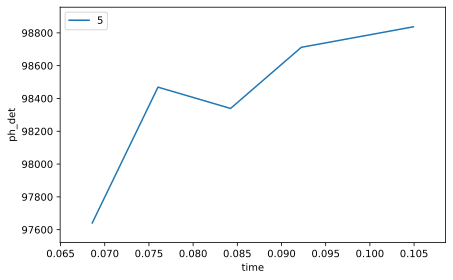

In [10]:
plt.gcf()  # Display a snapshot of the current state of the figure.

In [11]:
plt.gcf().canvas  # To avoid needing to scroll up, display the interactive canvas again here.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
# five sequential readings separated by a 1-second delay
RE(count([det], num=5, delay=1))



Transient Scan ID: 6     Time: 2020-05-14 20:40:02
Persistent Unique Scan ID: 'a648e5ce-69e2-4d8d-82ee-6443aea37bd8'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |     ph_det |
+-----------+------------+------------+
|         1 | 20:40:02.9 |     102155 |


|         2 | 20:40:03.8 |      99951 |


|         3 | 20:40:04.8 |      93978 |


|         4 | 20:40:05.9 |      95635 |


|         5 | 20:40:06.9 |     103101 |


+-----------+------------+------------+
generator count ['a648e5ce'] (scan num: 6)





('a648e5ce-69e2-4d8d-82ee-6443aea37bd8',)

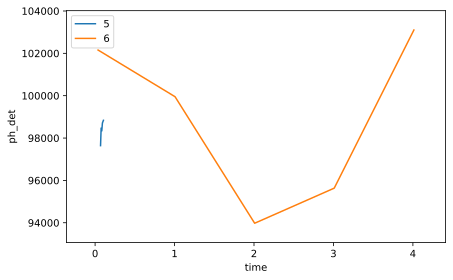

In [13]:
plt.gcf()  # Display a snapshot of the current state of the figure.

### Scan

Scan ``motor`` from -10 to 10, stopping at 15 equally-spaced points along the way and reading ``det``.

In [14]:
# Creating a figure explicitly in advance helps with the
# top-to-bottom flow of this notebook, but it is not necessary.
# If this is omitted, bluesky will cause a figure to appear
# during the RE(...) execution below.
plt.figure('ph_det vs motor_ph')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Figure size 640x480 with 0 Axes>

In [15]:
RE(scan([det], motor, -10, 10, 15))



Transient Scan ID: 7     Time: 2020-05-14 20:40:08
Persistent Unique Scan ID: 'fbf56354-bf61-4f8a-bcf4-f264cbaf6652'
New stream: 'primary'


+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 20:40:08.7 |    -10.000 |      13163 |


|         2 | 20:40:10.2 |     -8.571 |      22872 |


|         3 | 20:40:11.7 |     -7.143 |      37488 |


|         4 | 20:40:13.2 |     -5.714 |      49762 |


|         5 | 20:40:14.7 |     -4.286 |      71818 |


|         6 | 20:40:16.2 |     -2.857 |      83870 |


|         7 | 20:40:17.7 |     -1.429 |      93276 |


|         8 | 20:40:19.2 |      0.000 |     104996 |


|         9 | 20:40:20.7 |      1.429 |      92168 |


|        10 | 20:40:22.2 |      2.857 |      85320 |


|        11 | 20:40:23.6 |      4.286 |      71426 |


|        12 | 20:40:25.1 |      5.714 |      49282 |


|        13 | 20:40:26.6 |      7.143 |      37670 |


|        14 | 20:40:28.1 |      8.571 |      23043 |


|        15 | 20:40:29.6 |     10.000 |      13199 |
+-----------+------------+------------+------------+
generator scan ['fbf56354'] (scan num: 7)





('fbf56354-bf61-4f8a-bcf4-f264cbaf6652',)

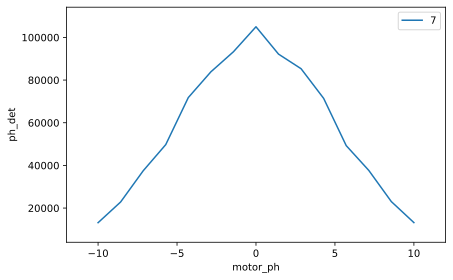

In [16]:
plt.gcf()  # Display a snapshot of the current state of the figure.

### Simulators

Bluesky includes utilities to inspecting plans before they are run. You can imagine various reasons you might want to do this. Example:

In [17]:
from bluesky.simulators import summarize_plan

summarize_plan(scan([det], motor, -1, 1, 3))

=================================== Open Run ===================================
motor_ph -> -1.0
  Read ['ph', 'motor_ph']
motor_ph -> 0.0
  Read ['ph', 'motor_ph']
motor_ph -> 1.0
  Read ['ph', 'motor_ph']
================================== Close Run ===================================


### Custom plan

Define a custom "plan", using the Python syntax ``yield from`` to dispatch out to built-in plans.

In [18]:
plt.gcf().canvas  # To avoid needing to scroll up, display the interactive canvas again here.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
# The plan_stubs module contains smaller plans.
# They can be used alone or as buildling blocks for larger plans.
from bluesky.plan_stubs import mv


def sweep_exposure_time(times):
    "Multiple scans: one per exposure time setting."
    for t in times:
        yield from mv(det.exp, t)
        yield from scan([det], motor, -10, 10, 5)
        
RE(sweep_exposure_time([0.01, 0.1, 1]))



Transient Scan ID: 8     Time: 2020-05-14 20:40:30
Persistent Unique Scan ID: '69bc2271-d294-4c74-8975-50994f323ce3'


New stream: 'primary'


+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 20:40:30.4 |    -10.000 |        154 |


|         2 | 20:40:35.5 |     -5.000 |        655 |


|         3 | 20:40:40.6 |      0.000 |        979 |


|         4 | 20:40:45.7 |      5.000 |        620 |


|         5 | 20:40:50.8 |     10.000 |        122 |
+-----------+------------+------------+------------+
generator scan ['69bc2271'] (scan num: 8)





Transient Scan ID: 9     Time: 2020-05-14 20:40:50
Persistent Unique Scan ID: '97c5b716-e62d-42cf-b8bf-cd462f9dde58'


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 20:40:51.1 |    -10.000 |       1395 |


|         2 | 20:40:56.2 |     -5.000 |       6045 |


|         3 | 20:41:01.3 |      0.000 |       9435 |


|         4 | 20:41:06.4 |      5.000 |       6215 |


|         5 | 20:41:11.5 |     10.000 |       1416 |
+-----------+------------+------------+------------+
generator scan ['97c5b716'] (scan num: 9)





Transient Scan ID: 10     Time: 2020-05-14 20:41:11
Persistent Unique Scan ID: '42e73282-2b6a-42a4-ba9e-a80246db1b8d'


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 20:41:11.8 |    -10.000 |      13854 |


|         2 | 20:41:16.9 |     -5.000 |      57911 |


|         3 | 20:41:22.0 |      0.000 |      98487 |


|         4 | 20:41:27.0 |      5.000 |      63511 |


|         5 | 20:41:32.1 |     10.000 |      13707 |
+-----------+------------+------------+------------+
generator scan ['42e73282'] (scan num: 10)





('69bc2271-d294-4c74-8975-50994f323ce3',
 '97c5b716-e62d-42cf-b8bf-cd462f9dde58',
 '42e73282-2b6a-42a4-ba9e-a80246db1b8d')

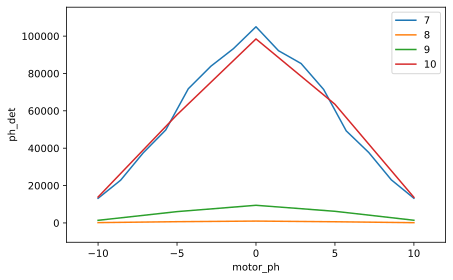

In [20]:
plt.gcf()  # Display a snapshot of the current state of the figure.

## Exercises

Q1: Above we ran a `count` with multiple readings separated by a fixed delay. The ``delay`` parameter also accepts a list of values. Try a `count` with a variable delay.


In [21]:
# Try your solution here. Fill in the blank:
# RE(count(____)))

Execute the following cell to reveal a solution:

In [22]:
%load solutions/count_variable_delay.py

Q2: Write a custom plan that scans the same region twice, first with coarse steps and then with fine steps.

In [23]:
# Try your solution here. Fill in the blank:
# def coarse_and_fine(detectors, motor, start, stop):
#     yield from scan(___)
#     yield from scan(___)
#
# RE(coarse_and_fine([det], motor, -10, 10))

In [24]:
%load solutions/scan_coarse_and_fine.py

Q3. All of the usages of scan we have seen so far scan from negative to positive. Scan from positive to negative.

In [25]:
# Try your solution here.

In [26]:
%load solutions/scan_positive_to_negative.py

Q4: The ``scan`` plan samples equally-spaced points. To sample *arbitrary* points, you can use ``list_scan``. Import it from the same module that we imported ``scan`` from, then use ``list_scan?`` to view its documentation and figure out how to use it. Scan the positions ``[1, 1, 2, 3, 5, 8]``.

In [27]:
# Try your solution here.

In [28]:
%load solutions/scan_fibonacci.py

Q5: What's wrong with this? (What does it do?)

In [29]:
# Broken example
def sweep_exposure_time(times):
    "Multiple scans: one per exposure time setting."
    for t in times:
        mv(det.exp, t)
        scan([det], motor, -10, 10, 15)

In [30]:
%load solutions/broken_sweep_exposure_time_explanation.txt